<a href="https://colab.research.google.com/github/codewithAshwani/Handwriting_text_ctc_Beam_search/blob/main/Handwriting_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2, numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from collections import Counter
import time
import numpy
from pickle import dump
from pickle import load
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Activation, Bidirectional, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,TimeDistributed, LSTM

```
Data file path 
```

In [ ]:
Dataset = "words.txt"
pickle_path = 'features.pkl'

**Get Sample ID**

In [ ]:
def sample_id(Dataset, numbers): 
    file = open(Dataset, mode= 'rt' , encoding= 'utf-8')
    text = file.readlines()
    dataset = list()
    for line in text[:numbers]:
        if not line or line[0]=='#':
            continue
        bad_samples_reference = ['a01-117-05-02', 'r06-022-03-05']  # known broken images in IAM dataset
        linesplit = line.strip().split(' ')

        fileNameSplit = linesplit[0].split('-')

        img_path = 'words/'+fileNameSplit[0]+'/'+fileNameSplit[0] + '-' + fileNameSplit[1]+'/'+linesplit[0]+'.png'   
        if linesplit[0] in bad_samples_reference:
            print('Ignoring known broken image:', img_path)
            continue 
        img_word = linesplit[-1]
        dataset.append(img_word)
    return dataset

In [ ]:
numbers = 10000
width = 128
height = 32  
dataset = sample_id(Dataset, numbers)

Ignoring known broken image: words/a01/a01-117/a01-117-05-02.png


**Load Data feature and label**

In [ ]:
def load_features(filename, dataset):
    # load all features
    x=[]
    y=[]
    all_features = load(open(filename, 'rb'))
    # filter features
    for k in dataset:  
        x.append(all_features[k])
        y.append(k) 
    return x,y

In [ ]:
# load image and label
x,y = load_features(pickle_path, dataset)
len(x)

9981

In [ ]:
characters = set(char for label in y for char in label)
# Mapping characters to integers
char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [ ]:
max_length = max([len(label) for label in y])
max_length

18

In [ ]:
len(characters)

74

In [ ]:
#padding of output lable
y2 = []
for i in range(len(y)):
    val = list(map(lambda x: list(characters).index(x), y[i]))
    while len(val)<(max_length):
        val.append(len(characters)+1)
    y2.append(val)

In [ ]:
y2[4000]

[32, 1, 19, 9, 65, 1, 28, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75]

In [ ]:
# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(np.asarray(x), np.asarray(y2), test_size=0.005, shuffle= True)

In [ ]:
x_train.shape, y_train.shape, x_valid.shape

((9931, 128, 32, 1), (9931, 18), (50, 128, 32, 1))

In [ ]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 16
steps_per_epoch = x_train.shape[0]//BATCH_SIZE
units = 512
dropout = 0.2
beam_widt = 3

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
BUFFER_SIZE_TEST = x_valid.shape[0]
dataset_test = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).shuffle(BUFFER_SIZE_TEST)
dataset_test = dataset_test.batch(1)

**Encoder** 

In [ ]:
class encoder(tf.keras.Model):
    def __init__(self, units, batch_size, characters, dropout, img_width, img_height):
        super(encoder, self).__init__()
        self.batch_size = batch_size
        self.units = units
        self.characters = characters
        self.dropout = dropout
        self.img_width = img_width
        self.img_height = img_height

        self.Conv2D1 = Conv2D(32,(3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")
        self.MaxPooling2D1 = MaxPooling2D((2, 2), name="pool1")
        self.Conv2D2 = Conv2D(64,(3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")
        self.MaxPooling2D2 = MaxPooling2D((2, 2), name="pool2")
        self.Conv2D3 = Conv2D(128,(3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")
        self.MaxPooling2D3 = MaxPooling2D((1, 1), name="pool2")

        self.Reshape= Reshape(target_shape=((self.img_width // 4), (self.img_height // 4) * 128), name="reshape")
        self.Dense=Dense(128, activation="relu", name="dense1")
        self.BidiLSTM1=Bidirectional(LSTM(units, return_sequences=True, dropout=self.dropout))
        self.BidiLSTM2=Bidirectional(LSTM(units, return_sequences=True, dropout=self.dropout))
        self.Dense1 = TimeDistributed(Dense(len(self.characters)+1, name="dense2"))
        self.Dense2 = TimeDistributed(Activation('softmax'), name='softmax')
    def call(self, x):
        x = self.Conv2D1(x)
        x = self.MaxPooling2D1(x)
        x = self.Conv2D2(x)
        x = self.MaxPooling2D2(x)
        x = self.Conv2D3(x)
        x = self.MaxPooling2D3(x)
        x = self.Reshape(x)
        x = self.Dense(x)
        x = self.BidiLSTM1(x)
        x = self.BidiLSTM2(x)
        x = self.Dense1(x)
        output = self.Dense2(x)
        return output

In [ ]:
encoder = encoder(units, BATCH_SIZE, characters, dropout, width, height)

**CTC Loss**

In [ ]:
optimizer = tf.keras.optimizers.Adam()

class CTC_Loss_Layer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.loss_func = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        label_length = tf.cast(tf.fill([batch_len, 1], label_length), dtype="int64")
        input_length = tf.cast(tf.fill([batch_len, 1], input_length), dtype="int64")



        loss = self.loss_func(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [ ]:
CTC_Layer = CTC_Loss_Layer()

In [ ]:
@tf.function
def train_step(x_batch_train, y_batch_train):
    loss = 0
    with tf.GradientTape() as tape:
        output = encoder(x_batch_train) 
        output = CTC_Layer(y_batch_train, output)
        loss = tf.math.reduce_mean(CTC_Layer.losses)

    batch_loss = (loss / y_batch_train.shape[1])   
    variables = encoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    for step, (x_batch_train, y_batch_train) in enumerate(dataset):
        batch_loss = train_step(x_batch_train, y_batch_train)
        total_loss += batch_loss
    print(f'Epoch {epoch+1} Loss {total_loss:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Loss 5.3644
Time taken for 1 epoch 20.19 sec

Epoch 2 Loss 35.3230
Time taken for 1 epoch 19.94 sec

Epoch 3 Loss 6.1941
Time taken for 1 epoch 19.92 sec

Epoch 4 Loss 1.9606
Time taken for 1 epoch 19.94 sec

Epoch 5 Loss 0.8642
Time taken for 1 epoch 19.92 sec

Epoch 6 Loss 0.4439
Time taken for 1 epoch 20.01 sec

Epoch 7 Loss 0.2543
Time taken for 1 epoch 19.97 sec

Epoch 8 Loss 0.1885
Time taken for 1 epoch 19.94 sec

Epoch 9 Loss 0.2040
Time taken for 1 epoch 19.97 sec

Epoch 10 Loss 0.2520
Time taken for 1 epoch 20.00 sec



In [ ]:
def greedy_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    resultn = np.array([i for i in tf.reshape(results, [max_length]).numpy() if i!=-1]) 
    output_text = tf.strings.reduce_join(num_to_char(resultn)).numpy().decode("utf-8")
    return output_text, results

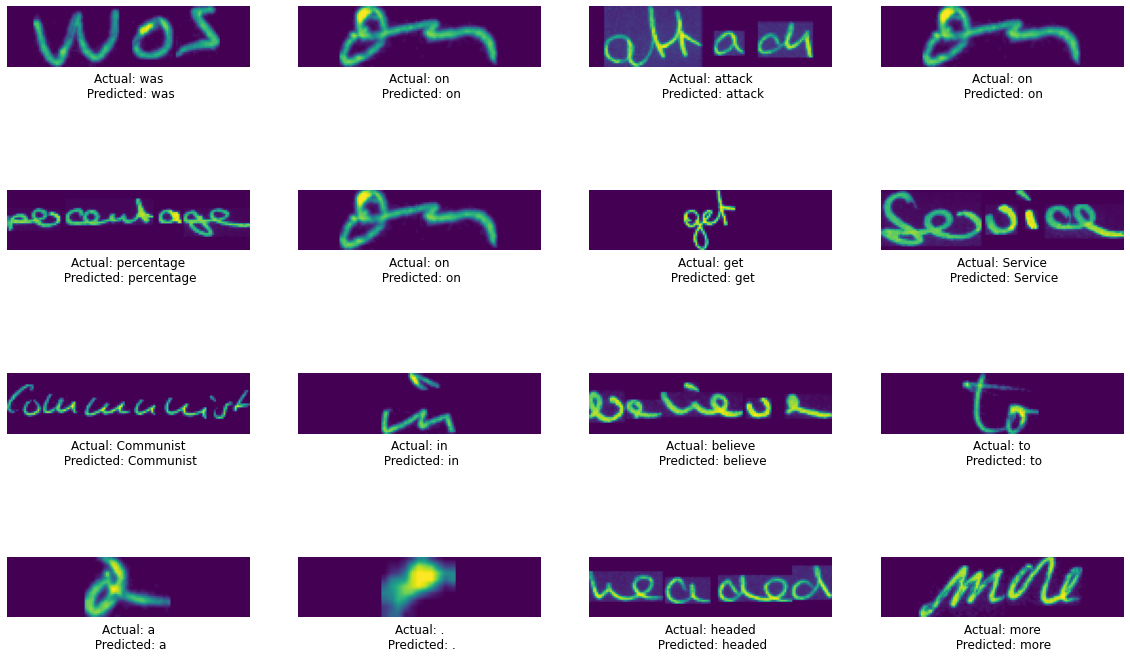

In [ ]:
plt.figure(figsize=(20,12))
j=0
for i, (x_batch_test, y_batch_test) in enumerate(dataset_test):
    preds = encoder(x_batch_test)
    pred_texts, pred = greedy_predictions(preds)
    y_batch = np.array([i for i in tf.reshape(y_batch_test, [max_length]).numpy() if i != (len(characters)+1)]) 
    label_true = tf.strings.reduce_join(num_to_char(y_batch)).numpy().decode("utf-8")
    j=j+1
    plt.subplot(4,4,i+1)    # the number of images in the grid is 4*4 (16)
    plt.subplots_adjust(hspace=0.8)
    x_batch_test = np.array(x_batch_test)
    x_batch_test = x_batch_test.reshape((x_batch_test.shape[1], x_batch_test.shape[2]))
    plt.imshow(x_batch_test.T)
    plt.title(f"Actual: {label_true}\n Predicted: {pred_texts}", fontsize = 12,  y=-0.6)
    plt.axis('off')  
    if j >= 16:
        break
plt.show()

In [ ]:
def beam_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=False, beam_width=3,
    top_paths=1)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    resultn = np.array([i for i in tf.reshape(results, [max_length]).numpy() if i!=-1]) 
    output_text = tf.strings.reduce_join(num_to_char(resultn)).numpy().decode("utf-8")
    return output_text, results

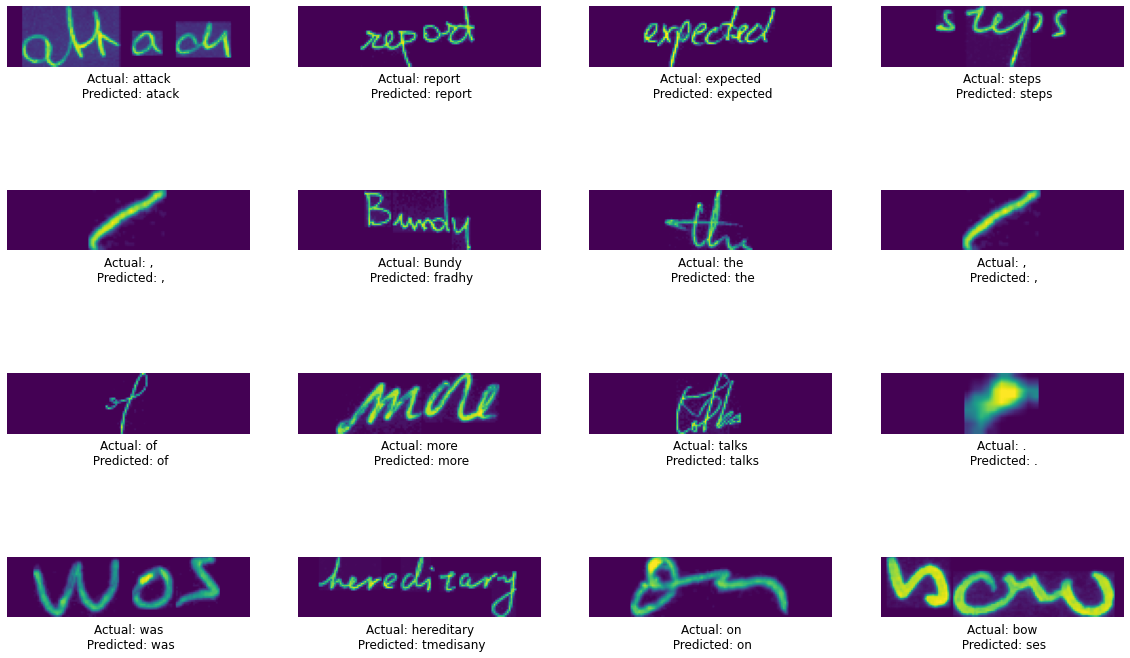

In [ ]:
plt.figure(figsize=(20,12))
j=0
for i, (x_batch_test, y_batch_test) in enumerate(dataset_test):
    preds = encoder(x_batch_test)
    pred_texts, pred = beam_predictions(preds)
    y_batch = np.array([i for i in tf.reshape(y_batch_test, [max_length]).numpy() if i != (len(characters)+1)]) 
    label_true = tf.strings.reduce_join(num_to_char(y_batch)).numpy().decode("utf-8")
    j=j+1
    plt.subplot(4,4,i+1)    # the number of images in the grid is 4*4 (16)
    plt.subplots_adjust(hspace=0.8)
    x_batch_test = np.array(x_batch_test)
    x_batch_test = x_batch_test.reshape((x_batch_test.shape[1], x_batch_test.shape[2]))
    plt.imshow(x_batch_test.T)
    plt.title(f"Actual: {label_true}\n Predicted: {pred_texts}", fontsize = 12,  y=-0.6)
    plt.axis('off')  
    if j >= 16:
        break
plt.show()